# Density-based clustering

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import seaborn as sns
from tqdm.notebook import tqdm

In [243]:
# read customer dataframe
df = pd.read_csv('datasets/customer_dataframe.csv', sep='\t', index_col=0)

Perform some dimensionality reduction by picking only the main attributes
for describing a customer's shopping behaviour

In [244]:
df_reduct = df[['TProd', 'MeanProdOrder', 'MeanSaleOrder', 'MeanPSale']]
df_reduct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TProd          4333 non-null   int64  
 1   MeanProdOrder  4333 non-null   float64
 2   MeanSaleOrder  4333 non-null   float64
 3   MeanPSale      4333 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 169.3 KB


In [245]:
df_reduct.describe()

,TProd,MeanProdOrder,MeanSaleOrder,MeanPSale
count,4333.000000,4333.000000,4333.000000,4333.000000
mean,1129.535657,201.104614,327.882896,3.492819
std,4692.695935,274.590134,395.336014,8.997404
min,0.000000,0.000000,-0.000000,0.122000
25%,157.000000,80.500000,155.050000,2.160000
50%,370.000000,140.167000,241.900000,2.834000
75%,971.000000,237.750000,371.560000,3.712000
max,196556.000000,7824.000000,9904.875000,434.650000


<AxesSubplot:>

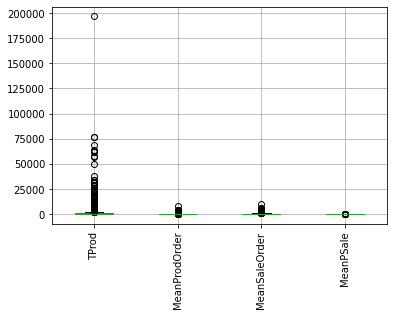

In [246]:
df_reduct.boxplot(list(df_reduct.columns), rot=90)

## Preprocessing - Normalization

In [247]:
# standard normalization: remove mean and scale to unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_norm = scaler.fit_transform(df_reduct.values)
df_norm = pd.DataFrame(df_norm, columns=df_reduct.columns)

In [248]:
df_norm.describe()

,TProd,MeanProdOrder,MeanSaleOrder,MeanPSale
count,4.333000e+03,4.333000e+03,4.333000e+03,4.333000e+03
mean,1.311872e-17,3.279680e-17,-5.493464e-17,4.181592e-17
std,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00
min,-2.407286e-01,-7.324656e-01,-8.294735e-01,-3.746867e-01
25%,-2.072685e-01,-4.392675e-01,-4.372302e-01,-1.481508e-01
50%,-1.618735e-01,-2.219477e-01,-2.175183e-01,-7.323169e-02
75%,-3.378739e-02,1.334703e-01,1.104937e-01,2.436327e-02
max,4.164962e+01,2.776420e+01,2.422774e+01,4.792570e+01


<AxesSubplot:>

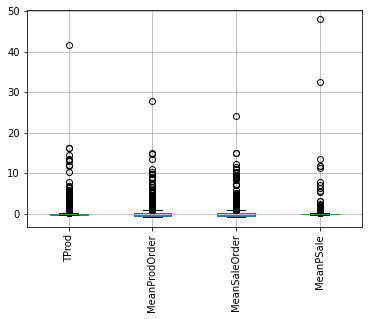

In [249]:
df_norm.boxplot(list(df_norm.columns), rot=90)

## DBSCAN

In [250]:
"""
# single dbscan
dbscan = DBSCAN(eps=0.75, min_samples=5)
dbscan.fit(df_norm)
np.unique(dbscan.labels_, return_counts=True)

print(f"Number of clusters: {len(np.unique(dbscan.labels_[dbscan.labels_ >= 0], return_counts=True)[0])}")
if -1 in dbscan.labels_:
    print(f"Number of classified data points: {sum(np.unique(dbscan.labels_, return_counts=True)[1][1 : ])}")
    print(f"Number of NON-classified (noisy) data points: {np.unique(dbscan.labels_, return_counts=True)[1][0]}")
"""

'\n# single dbscan\ndbscan = DBSCAN(eps=0.75, min_samples=5)\ndbscan.fit(df_norm)\nnp.unique(dbscan.labels_, return_counts=True)\n\nprint(f"Number of clusters: {len(np.unique(dbscan.labels_[dbscan.labels_ >= 0], return_counts=True)[0])}")\nif -1 in dbscan.labels_:\n    print(f"Number of classified data points: {sum(np.unique(dbscan.labels_, return_counts=True)[1][1 : ])}")\n    print(f"Number of NON-classified (noisy) data points: {np.unique(dbscan.labels_, return_counts=True)[1][0]}")\n'

In [251]:
from scipy.spatial.distance import pdist, squareform
dist = pdist(X=df_norm, metric='euclidean')  #pair-wise distance: how every record is far from all others
dist = squareform(dist) #distance matrix given the vector dist

In [252]:
k = 5
kth_distances = list()
# for every row of the distance matrix...
for d in dist:
    # argsort returns the indexes that would sort d
    # Pick k-th elem = k-th nn of i-th record ( for i in range(len(df_norm)) )
    index_kth_distance = np.argsort(d)[k]
    # kth_distances will be as long as the number of records in the dataframe
    # Each elem of kth_distance will be the distance of the i-th record from its k-th nn
    kth_distances.append(d[index_kth_distance])

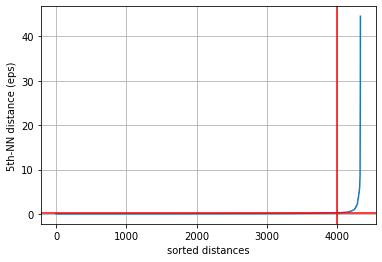

Elbow of 5th-NN distances plot: x = 4000 --> eps = 0.25683869925326774


In [253]:
plt.figure(num=1)
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel(f'{k}th-NN distance (eps)')
plt.xlabel('sorted distances')
plt.tick_params(axis='both', which='major')
plt.grid()
elb = 4000
plt.axvline(x=elb, color='red', linestyle='-')
plt.axhline(y=sorted(kth_distances)[elb], color='red', linestyle='-')
plt.show()
print(f"Elbow of {k}th-NN distances plot: x = {elb} --> eps = {sorted(kth_distances)[elb]}")

### Grid search for _eps_ and <i>min_samples</i>

In [254]:
from sklearn.neighbors import NearestNeighbors

# func to get metrics to evaluate the clustering done with certain eps and min_samples
def get_metrics(eps, ms, dataset, iter_):

    # Fitting
    dbscan = DBSCAN(eps=eps, min_samples=ms)
    dbscan.fit(dataset)

    # Mean Noise Point Distance metric
    noise_indices = (dbscan.labels_ == -1)  #list of booleans
    if True in noise_indices:
        nbrs = NearestNeighbors(n_neighbors = 5).fit(dataset)
        distances, _ = nbrs.kneighbors(dataset)   #returns indices of and distances to the neighbors of each point
        noise_distances = distances[noise_indices, 1 : ]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None

    # Number of found Clusters metric
    number_of_clusters = len(np.unique(dbscan.labels_[dbscan.labels_ >= 0]))

    # Log
    print("%3d | Tested with eps = %3s and min_samples = %3s | %5s\t%4s" % (iter_, eps, ms, str(noise_mean_distance), number_of_clusters))

    return noise_mean_distance, number_of_clusters

In [255]:
# Lists for the params to test in the grid search
gs_eps_list = [round(eps, 2) for eps in np.arange(0.01, 5, 0.05)]
gs_ms_list = range(3, 12, 2)

print("Grid search parameters:")
print("eps:", gs_eps_list)
print("min_samples:", list(gs_ms_list))

Grid search parameters:
eps: [0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51, 0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96, 1.01, 1.06, 1.11, 1.16, 1.21, 1.26, 1.31, 1.36, 1.41, 1.46, 1.51, 1.56, 1.61, 1.66, 1.71, 1.76, 1.81, 1.86, 1.91, 1.96, 2.01, 2.06, 2.11, 2.16, 2.21, 2.26, 2.31, 2.36, 2.41, 2.46, 2.51, 2.56, 2.61, 2.66, 2.71, 2.76, 2.81, 2.86, 2.91, 2.96, 3.01, 3.06, 3.11, 3.16, 3.21, 3.26, 3.31, 3.36, 3.41, 3.46, 3.51, 3.56, 3.61, 3.66, 3.71, 3.76, 3.81, 3.86, 3.91, 3.96, 4.01, 4.06, 4.11, 4.16, 4.21, 4.26, 4.31, 4.36, 4.41, 4.46, 4.51, 4.56, 4.61, 4.66, 4.71, 4.76, 4.81, 4.86, 4.91, 4.96]
min_samples: [3, 5, 7, 9, 11]


Dataframes to contain the results of the grid search

In [256]:
# Dataframe for the metric on the avg distance of the noise points from the K nearest ones
results_noise = pd.DataFrame(
    data = np.zeros((len(gs_eps_list),len(gs_ms_list))), # Empty dataframe
    columns = gs_ms_list,
    index = gs_eps_list
)

# Dataframe for the metric on the number of clusters
results_clusters = pd.DataFrame(
    data = np.zeros((len(gs_eps_list),len(gs_ms_list))), # Empty dataframe
    columns = gs_ms_list,
    index = gs_eps_list
)

Grid search cycle:

In [257]:
# Grid search cycle
i = 0

print("ITER| INFO%s |  DIST    # CLUSTERS" % (' '*39))
print("-"*73)

for eps in tqdm(gs_eps_list, total=len(gs_eps_list), desc='Proceeding of grid search'):
    for ms in gs_ms_list:
        i += 1

        # Compute metrics
        noise_metric, clusters_metric = get_metrics(eps, ms, df_norm, i)

        # Insert results in the apposite dataframes
        results_noise.loc[eps, ms] = noise_metric
        results_clusters.loc[eps, ms] = clusters_metric

ITER| INFO                                        |  DIST    # CLUSTERS
-------------------------------------------------------------------------
  1 | Tested with eps = 0.01 and min_samples =   3 | 0.144	   6
  2 | Tested with eps = 0.01 and min_samples =   5 | 0.143	   0
  3 | Tested with eps = 0.01 and min_samples =   7 | 0.143	   0
  4 | Tested with eps = 0.01 and min_samples =   9 | 0.143	   0
  5 | Tested with eps = 0.01 and min_samples =  11 | 0.143	   0
  6 | Tested with eps = 0.06 and min_samples =   3 | 0.303	  69
  7 | Tested with eps = 0.06 and min_samples =   5 | 0.258	  24
  8 | Tested with eps = 0.06 and min_samples =   7 | 0.232	  11
  9 | Tested with eps = 0.06 and min_samples =   9 | 0.217	   6
 10 | Tested with eps = 0.06 and min_samples =  11 | 0.205	   6
 11 | Tested with eps = 0.11 and min_samples =   3 | 0.604	  33
 12 | Tested with eps = 0.11 and min_samples =   5 |  0.51	  10
 13 | Tested with eps = 0.11 and min_samples =   7 | 0.446	   5
 14 | Tested with eps 

KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("Number of clusters")
ax1.set_xlabel("min_samples")
ax2.set_xlabel("min_samples")
ax1.set_ylabel("epsilon")
ax2.set_ylabel("epsilon")
plt.show()
